In [198]:
%pylab inline
# Pandas is a nice utilitiy that enables some easy data manipulation, especially from a csv
import pandas as pd
# Numpy lets us work with arrays
import numpy as np
# Sklearn provides various modules with a common API
from sklearn import svm, tree, neighbors, neural_network
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

# import pickle
import pickle

# models

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [199]:
# Read in our csv files downloaded from Kaggle
train_data = pd.read_csv('train.csv').set_index("PassengerId")
test_data = pd.read_csv('test.csv').set_index("PassengerId")

In [200]:
# We can use .head() to get just the first few rows of the data.
train_data.head()
# Note how the notebook nicely displays the output for us

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [201]:
test_data.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [202]:
train_data.columns[train_data.isna().any()].tolist()

['Age', 'Cabin', 'Embarked']

In [203]:
def parse_title(df):
    # title
    df['Title'] = df.Name.str.split(',').str[1].str.split('.').str[0].str.strip()
    df['Title'] = df.Name.str.split(',').str[1].str.split('.').str[0].str.strip()
    df['Title'] = df['Title'].replace('Ms','Miss')
    df['Title'] = df['Title'].replace('Mlle','Miss')
    df['Title'] = df['Title'].replace('Mme','Mrs')
    return df

def process_name(df):
    # parse title first
    df = parse_title(df)
    df['LastName'] = df.Name.str.split(',').str[0]
    # get information about sex from title
    df['IsWomanOrBoy'] = ((df.Title == 'Master') | (df.Sex == 'female'))
    # find families
    family = df.groupby(df.LastName).Survived
    # count woman or boy
#     df['WomanOrBoyCount'] = family.transform(lambda s: s[df.IsWomanOrBoy].fillna(0).count())
#     df['WomanOrBoyCount'] = df.mask(df.IsWomanOrBoy, df.WomanOrBoyCount - 1, axis=0)
#     df['FamilySurvivedCount'] = family.transform(lambda s: s[df.IsWomanOrBoy].fillna(0).sum())
#     df['FamilySurvivedCount'] = df.mask(df.IsWomanOrBoy, df.FamilySurvivedCount - df.Survived.fillna(0), axis=0)
#     df['WomanOrBoySurvived'] = df.FamilySurvivedCount / df.WomanOrBoyCount.replace(0, np.nan)
#     df.WomanOrBoyCount = df.WomanOrBoyCount.replace(np.nan, 0)
#     df['Alone'] = (df.WomanOrBoyCount == 0)
    return df

In [204]:
def fill_missing(df):
    # Embarked
    df['Embarked'] = df['Embarked'].fillna('S')
    # Cabin, Deck
    df['Deck'] = df['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'M')
    df.loc[(df['Deck'] == 'T'), 'Deck'] = 'A'

    # Thanks to https://www.kaggle.com/erinsweet/simpledetect
    # Fare
    med_fare = df.groupby(['Pclass', 'Parch', 'SibSp']).Fare.median()[3][0][0]
    df['Fare'] = df['Fare'].fillna(med_fare)
    #Age
    df['Age'] = df.groupby(['Sex', 'Pclass', 'Title'])['Age'].apply(lambda x: x.fillna(x.median()))
    # Family_Size
    df['Family_Size'] = df['SibSp'] + df['Parch'] + 1
    return df

In [205]:
def encode_types(df):
    numerics = ['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    categorical_columns = []
    features = df.columns.values.tolist()
    for col in features:
        if df[col].dtype in numerics: continue
        categorical_columns.append(col)
    # Encoding categorical features
    for col in categorical_columns:
        if col in df.columns:
            le = LabelEncoder()
            le.fit(list(df[col].astype(str).values))
            df[col] = le.transform(list(df[col].astype(str).values))
    return df
    

In [206]:
# don't drop name, ticket, cabin
# train_data.drop(columns=['Name', 'Ticket', 'Cabin'], inplace=True)

# combine train and test into single df for preprocessing --> becareful bc test won't have survived column
df = pd.concat([train_data, test_data], axis=0, sort=False)
df.head()

df = process_name(df)

# train_nan_map = {'Age': train_data['Age'].mean(), 'Fare': train_data['Fare'].mean(), 'Embarked': train_data['Embarked'].mode()[0]}
# test_nan_map = {'Age': test_data['Age'].mean(), 'Fare': test_data['Fare'].mean(), 'Embarked': test_data['Embarked'].mode()[0]}

# train_data.fillna(value=train_nan_map, inplace=True)
# test_data.fillna(value=test_nan_map, inplace=True)

# columns_map = {'Embarked': {'C': 0, 'Q': 1, 'S': 2}, 'Sex': {'male': 0, 'female': 1}}
# train_data.replace(columns_map, inplace=True)
# test_data.replace(columns_map, inplace=True)

# fill in missing
df = fill_missing(df)

# drop these columns
cols_to_drop = ['Name','Ticket','Cabin']
df = df.drop(cols_to_drop, axis=1)

# encode the string datatypes using LabelEncoder
df = encode_types(df)

# separate into data and survived label
train_data, test_data = df.loc[train_data.index], df.loc[test_data.index]
X_train = train_data.loc[:, train_data.columns != 'Survived']
y_train = train_data.loc[:, 'Survived']

# try kfold from scikit-learn
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.33, random_state=10)

print(X_train.head())
print(y_train.head())
print(test_data.head())

             Pclass  Sex   Age  SibSp  Parch    Fare  Embarked  Title  \
PassengerId                                                             
464               2    1  48.0      0      0  13.000         2     10   
160               3    1   6.0      8      2  69.550         2      8   
48                3    0  18.0      0      0   7.750         1      9   
403               3    0  21.0      1      0   9.825         2      9   
619               2    0   4.0      2      1  39.000         2      9   

             LastName  IsWomanOrBoy  Deck  Family_Size  
PassengerId                                             
464               524             0     7            1  
160               700             1     7           11  
48                586             1     7            1  
403               388             1     7            2  
619                66             1     5            4  
PassengerId
464    0.0
160    0.0
48     1.0
403    0.0
619    1.0
Name: Survived, dtype:

In [207]:
train_data.columns[train_data.isna().any()].tolist()
train_data[train_data['Embarked'].isna() == True]
#train_data['Embarked']
#test_data.columns[test_data.isna().any()].tolist()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,LastName,IsWomanOrBoy,Deck,Family_Size
PassengerId,,,,,,,,,,,,,


## Keeping track of models

For now we will keep a dictionary with all the models performance

Model will map to (fnr, fpr)

Next we will pickle them so we don't have to waste time retraining

In [224]:
# fit and evaluate model
y_truth = y_test.values
def eval(model):
    model.fit(X_train.values, y_train.values)
    print("Accuracy:", model.score(X_test.values, y_test.values))
    y_pred = model.predict(X_test.values)
    tn, fp, fn, tp = confusion_matrix(y_truth, y_pred).ravel()
    print("")
    print("Confusion Matrix")
    print(confusion_matrix(y_truth, y_pred, labels=[0, 1]))
    print("")
    print("True Negatives", tn)
    print("False Positives", fp)
    print("False Negatives", fn)
    print("True Positives", tp)
    print("")
    fpr = fp / (fp + tn)
    print("FPR", fpr)
    fnr = fn / (fn + tp)
    print("FNR", fnr)
    models[type(model).__name__] = (fpr, fnr)
    print(models)

In [226]:
models = {}

In [227]:
tree_clf = tree.DecisionTreeClassifier()
eval(tree_clf)

Accuracy: 0.7864406779661017

Confusion Matrix
[[154  37]
 [ 26  78]]

True Negatives 154
False Positives 37
False Negatives 26
True Positives 78

FPR 0.193717277486911
FNR 0.25
{'DecisionTreeClassifier': (0.193717277486911, 0.25)}


In [228]:
knn_clf = neighbors.KNeighborsClassifier()
eval(knn_clf)

Accuracy: 0.6745762711864407

Confusion Matrix
[[155  36]
 [ 60  44]]

True Negatives 155
False Positives 36
False Negatives 60
True Positives 44

FPR 0.18848167539267016
FNR 0.5769230769230769
{'DecisionTreeClassifier': (0.193717277486911, 0.25), 'KNeighborsClassifier': (0.18848167539267016, 0.5769230769230769)}


In [229]:
NN_clf = neural_network.MLPClassifier()
eval(NN_clf)

Accuracy: 0.7762711864406779

Confusion Matrix
[[178  13]
 [ 53  51]]

True Negatives 178
False Positives 13
False Negatives 53
True Positives 51

FPR 0.06806282722513089
FNR 0.5096153846153846
{'DecisionTreeClassifier': (0.193717277486911, 0.25), 'KNeighborsClassifier': (0.18848167539267016, 0.5769230769230769), 'MLPClassifier': (0.06806282722513089, 0.5096153846153846)}


In [230]:
svm_clf = svm.SVC(kernel='linear')
eval(svm_clf)

Accuracy: 0.8338983050847457

Confusion Matrix
[[168  23]
 [ 26  78]]

True Negatives 168
False Positives 23
False Negatives 26
True Positives 78

FPR 0.12041884816753927
FNR 0.25
{'DecisionTreeClassifier': (0.193717277486911, 0.25), 'KNeighborsClassifier': (0.18848167539267016, 0.5769230769230769), 'MLPClassifier': (0.06806282722513089, 0.5096153846153846), 'SVC': (0.12041884816753927, 0.25)}


Confusion matrix, without normalization
[[168  23]
 [ 26  78]]


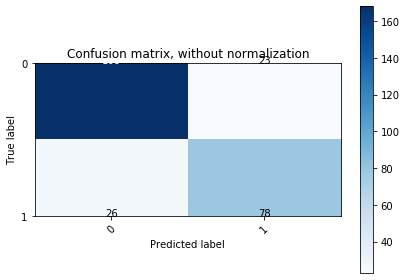

In [231]:
import itertools
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_truth, y_pred)
class_names=['0', '1']
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

plt.show()

In [18]:
predictions = svm_clf.predict(test_data.values)

In [19]:
type(predictions)

numpy.ndarray

In [20]:
pred_df = pd.DataFrame(predictions, index=test_data.index, columns=['Survived'])
type(pred_df)

pandas.core.frame.DataFrame

In [21]:
pred_df.to_csv('predictions.csv', header=True, sep=',')

## Function to display pareto front

We will give it the model dict and all the fpr and fnr that we have

TypeError: cannot unpack non-iterable numpy.float64 object

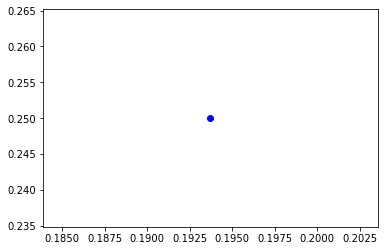

In [235]:
def pareto_frontier(models):
    for model in models:
        fnr, fpr = models[model]
#         plt.scatter(pop_1, pop_2, color='b')
#         plt.scatter(fitness_1, fitness_2, color='r')
        plt.scatter(fnr, fpr, color='b')
        plt.annotate(str(model), fnr, fpr)
        # plt.plot(fnr, fpr, color='r', drawstyle='steps-post')
        plt.xlabel("FNR")
        plt.ylabel("FPR")
        plt.title("Pareto Front")
    plt.show()
pareto_frontier(models)